In [344]:
library(dplyr)
library(tsibble)
library(fpp3) 
library(ggplot2)
library(corrplot)
library(ggcorrplot)


library(dplyr)
library(tsibble)
library(fpp3) 

options(repr.plot.width=25)

evaluation <- read.csv('Datasets/sales_test_evaluation_afcs_2024.csv')

calendar <- read.csv('Datasets/calendar_afcs2024.csv')
prices <- read.csv('Datasets/sell_prices_afcs2024.csv')
sales_train <- read.csv('Datasets/sales_train_validation_afcs2024.csv')
sales_val <- read.csv('Datasets/sales_test_validation_afcs2024.csv')

In [284]:
# Transpose sale CSV to match forcasting-usable format
# After transpose, ensure datatypes are int, surpress row names being selected in df

sales_transposed <- t(sales_train)
sales_df <- as.data.frame(sales_transposed[-1,]) %>% mutate_all(as.integer)
colnames(sales_df) <- sales_transposed[1,]
row.names(sales_df) <- NULL

#sales_df <- tibble::rownames_to_column(sales_df, "Day")
#sales_ts <- as_tsibble(sales_df, index = Day)
#sales_ts <- as_tsibble(sales_df)

# Count totals over the rows, just as a possible informative data about overall food items sales
# Add day counter to both df's to make merging possible (otherwise no key)

sales_df$total <- rowSums(sales_df)
sales_df$day <- 1:nrow(sales_df)
calendar$day <- 1:nrow(calendar)

In [285]:
# Merge dataframes and convert to tsibble 

calendar_sales <- merge(calendar,sales_df)
calendar_sales <- calendar_sales %>% as_tsibble(index = day)
calendar_sales$is_event <- ifelse(calendar_sales$event_name_1 != "NA", 1, 0)


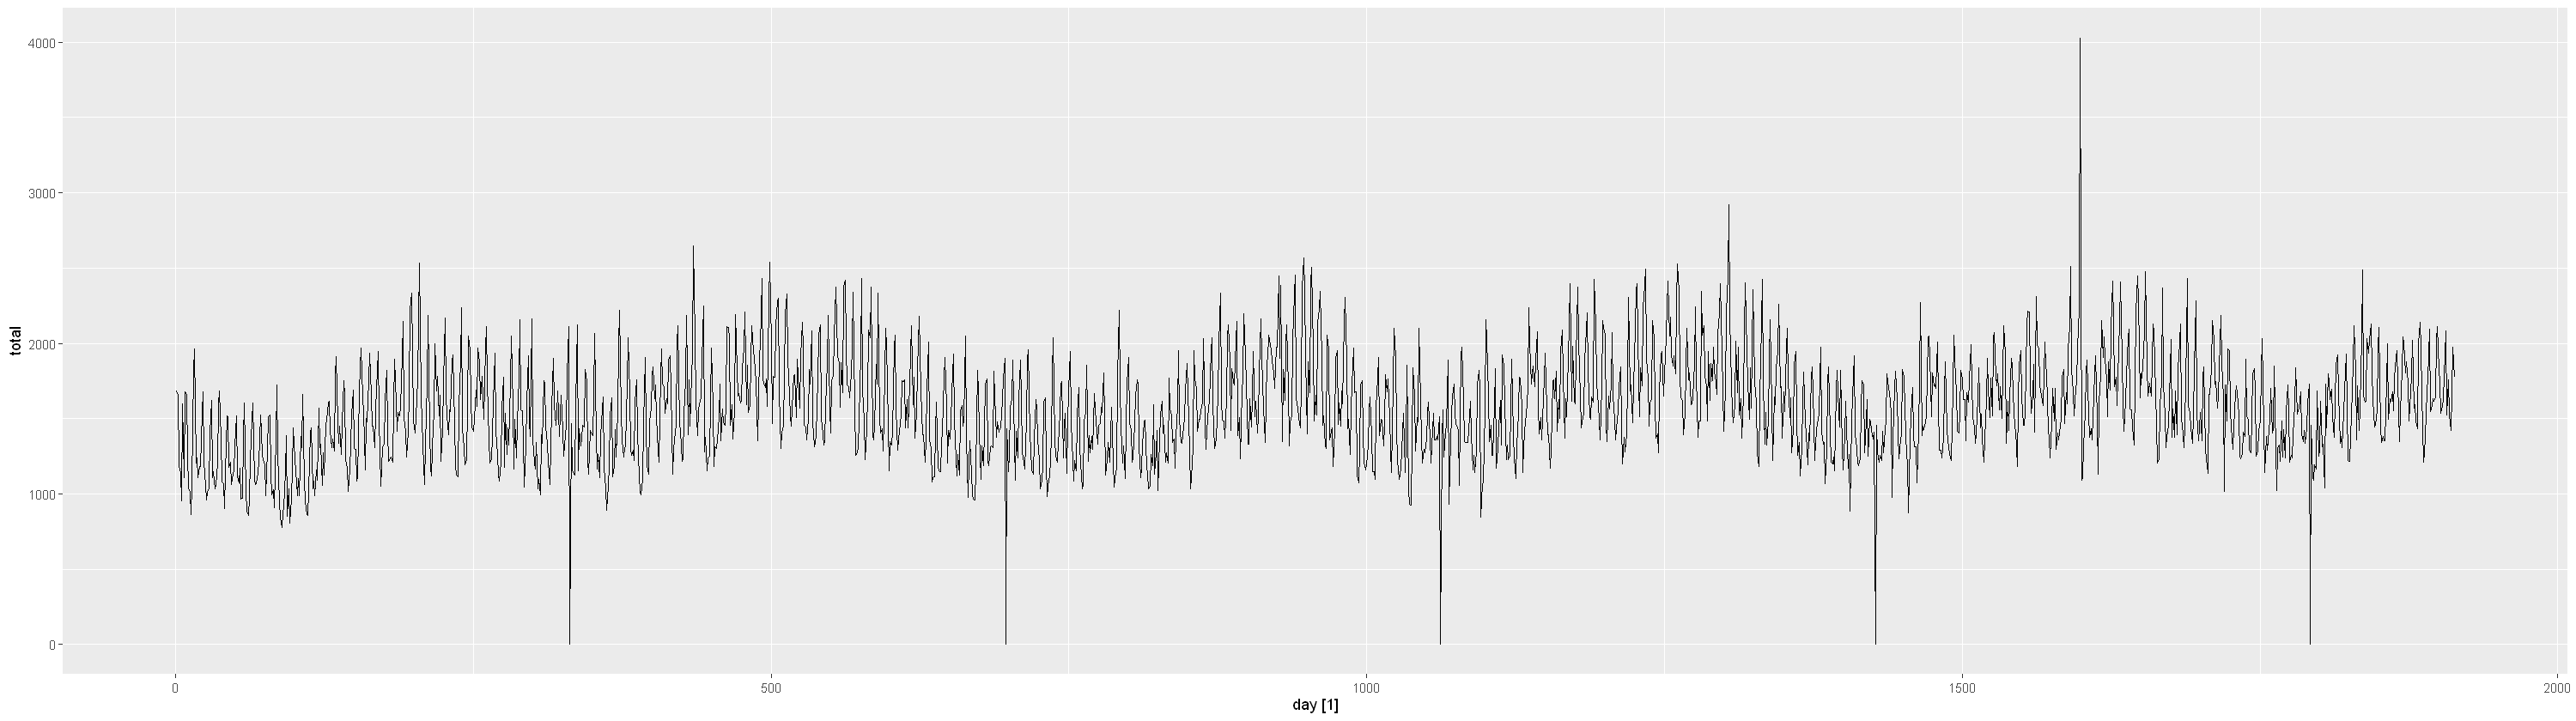

In [286]:
# Overall Food sales, informative. See cyclic behavior 

calendar_sales %>% autoplot(total)

In [287]:
is_regular(calendar_sales)

[1] TRUE

In [288]:
# Probably closed on christmas, sales is are aprox 0.
# Positive outlier on jun 15 2015, 4027 sales for some reason

calendar_sales[calendar_sales$total <=5, ]
calendar_sales[calendar_sales$total >=3500, ]

day,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,⋯,FOODS_3_820_TX_3_validation,FOODS_3_821_TX_3_validation,FOODS_3_822_TX_3_validation,FOODS_3_823_TX_3_validation,FOODS_3_824_TX_3_validation,FOODS_3_825_TX_3_validation,FOODS_3_826_TX_3_validation,FOODS_3_827_TX_3_validation,total,is_event
<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
331,12/25/2011,11148,Sunday,2,12,2011,Christmas,National,NA,⋯,0,0,0,0,0,0,0,0,2,1
697,12/25/2012,11248,Tuesday,4,12,2012,Christmas,National,NA,⋯,0,0,0,0,0,0,0,0,2,1
1062,12/25/2013,11348,Wednesday,5,12,2013,Christmas,National,NA,⋯,0,0,0,0,0,0,0,0,1,1
1427,12/25/2014,11447,Thursday,6,12,2014,Christmas,National,NA,⋯,0,0,0,0,0,0,0,0,4,1
1792,12/25/2015,11547,Friday,7,12,2015,Christmas,National,NA,⋯,0,0,0,0,0,0,0,0,2,1


day,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,⋯,FOODS_3_820_TX_3_validation,FOODS_3_821_TX_3_validation,FOODS_3_822_TX_3_validation,FOODS_3_823_TX_3_validation,FOODS_3_824_TX_3_validation,FOODS_3_825_TX_3_validation,FOODS_3_826_TX_3_validation,FOODS_3_827_TX_3_validation,total,is_event
<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1599,6/15/2015,11520,Monday,3,6,2015,NA,NA,NA,⋯,1,1,4,0,0,0,2,0,4027,NA


In [289]:
calendar2 <- calendar 
calendar2$name <- 1:nrow(calendar)
sales <- sales_train %>% pivot_longer (2:ncol(sales_train)) 
sales$name <- gsub("d_", "", sales$name)
sales$id <- gsub("_TX_3_validation", "" ,sales$id)
sales$name <- as.integer(sales$name)


In [290]:
calendar2_sales <- left_join(sales,calendar2, by='name') 
calendar2_sales$date <- as.Date(calendar2_sales$date, format = "%m/%d/%Y")
calendar2_sales <- calendar2_sales %>% as_tsibble(index = date , key = id)
calendar2_sales <- left_join(calendar2_sales, prices, by = c("wm_yr_wk" = "wm_yr_wk", "id"="item_id"))
#calendar2_sales$is_event <- ifelse(calendar2_sales$event_name_1 != "NA", 1, 0)

In [291]:
weekdays <- list('Monday', 'Tuesday', 'Wednesday', 'Thursday')
weekend <- list('Friday','Saturday')

In [292]:
calendar2_sales$is_weekend <- ifelse(calendar2_sales$weekday %in% weekend, 1, 0)
calendar2_sales$event_name_1 <- replace(calendar2_sales$event_name_1, is.na(calendar2_sales$event_name_1), 0)
calendar2_sales$is_event <- ifelse(calendar2_sales$event_name_1 != 0, 1, 0)

final_data <- calendar2_sales[c("id","name","value",'date','wday','wm_yr_wk','weekday','month', 'year','event_name_1','event_type_1','snap_TX','sell_price','is_event','is_weekend')]
final_data_numeric <- final_data[c('id','name','value','month','sell_price','is_event','is_weekend')]

final_data_numeric_2 <- final_data[c('id','name','value','month','sell_price','is_event','is_weekend')]
final_data_numeric_2$id <- gsub("FOODS_3_", "" ,final_data_numeric_2$id)

final_data_numeric_3 <- final_data[c('value','wday','month','sell_price','is_event','is_weekend', 'snap_TX')]
final_data_numeric_4 <- final_data[c('value','wday','month','sell_price','is_event','is_weekend', 'snap_TX')]
names(final_data_numeric_4)[names(final_data_numeric_4) == 'value'] <- 'Amount sold'

final_data_numeric$value <- as.double(final_data_numeric$value)
final_data_numeric$name <- as.double(final_data_numeric$name)
final_data_numeric$month <- as.double(final_data_numeric$month)

In [294]:
cormat

,Amount sold,wday,month,sell_price,is_event,is_weekend,snap_TX
Amount sold,1.00,-0.03,0.00,-0.13,0.00,0.03,0.02
wday,-0.03,1.00,0.00,0.00,-0.04,-0.29,0.00
month,0.00,0.00,1.00,0.00,-0.07,0.00,0.00
sell_price,-0.13,0.00,0.00,1.00,0.00,0.00,0.00
is_event,0.00,-0.04,-0.07,0.00,1.00,-0.04,0.01
is_weekend,0.03,-0.29,0.00,0.00,-0.04,1.00,0.01
snap_TX,0.02,0.00,0.00,0.00,0.01,0.01,1.00


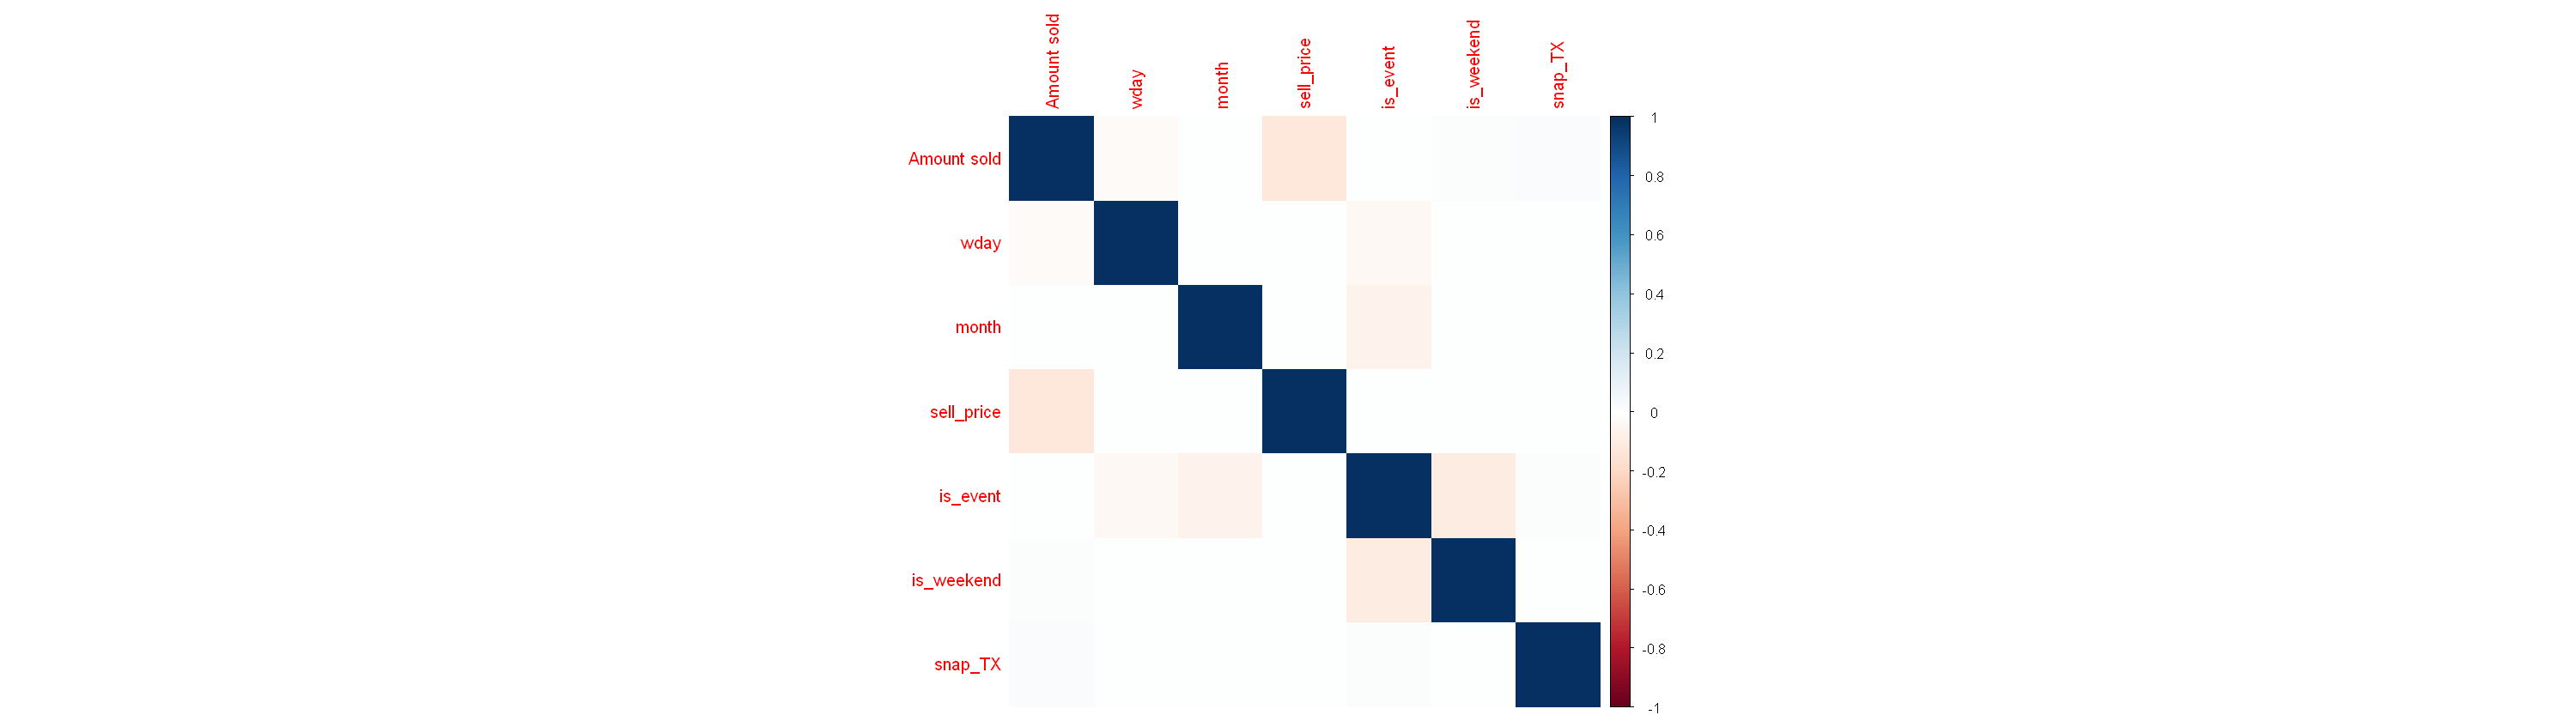

In [298]:
cormat <- round(cor(final_data_numeric_4, use = "pairwise.complete.obs"),2)
corrplot(cormat, method = "color")

In [397]:
x <-as_tsibble(final_data_numeric, index="name", key="id" )

In [398]:
arima <- x %>% model(ARIMA(value)) %>% forecast(h=28)

Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning 

In [461]:
eval_long$name <- (eval_long$name-28)
eval_long <- as_tsibble(eval_long, index="name", key="id")


In [426]:
arima_rounded <- arima
arima_rounded$.mean <- ceiling(arima_rounded$.mean)

In [363]:
sales_val_long <- sales_val %>% pivot_longer (2:ncol(sales_val))
sales_val_long$name <- gsub ("d_", "" ,sales_val_long$name)
sales_val_long$id <- gsub ("_TX_3_validation", "" ,sales_val_long$id)
sales_val_long$name <- as.integer(sales_val_long$name)
sales_val_long <-as_tsibble(sales_val_long, index="name", key="id" )

In [462]:
eval_long <- evaluation %>% pivot_longer (2:ncol(evaluation))
eval_long$name <- gsub ("d_", "" ,eval_long$name)
eval_long$id <- gsub ("_TX_3_validation", "" ,eval_long$id)
eval_long$name <- as.integer(eval_long$name)
eval_long <-as_tsibble(eval_long, index="name", key="id" )
eval_long$name <- (eval_long$name-28)
eval_long <- as_tsibble(eval_long, index="name", key="id")

In [45]:
#Validation set results
arima_results <- summary(accuracy(arima,sales_val_long) %>% select(ME:MAE))

In [415]:
arima_rmse <- summary(accuracy(arima_rounded, eval_long) %>% select(ME:MAE))

In [416]:
arima_rmse

       ME                 RMSE              MAE          
 Min.   :-11.90197   Min.   : 0.1822   Min.   : 0.03571  
 1st Qu.: -0.22039   1st Qu.: 0.6572   1st Qu.: 0.54037  
 Median :  0.01877   Median : 1.1948   Median : 0.91017  
 Mean   :  0.28704   Mean   : 2.1621   Mean   : 1.66061  
 3rd Qu.:  0.38596   3rd Qu.: 1.9853   3rd Qu.: 1.59565  
 Max.   : 23.32143   Max.   :27.2464   Max.   :23.32143  

In [452]:
arima_rounded2 <- as_tsibble(arima_rounded2, index="name", key="id" )

In [460]:
arima_rounded_results <- summary(accuracy(arima,eval_long) %>% select(ME:MAE))


Warning message:
"The future dataset is incomplete, incomplete out-of-sample data will be treated as missing. 
28 observations are missing between 1914 and 1941"


In [330]:
arima_rounded_results

       ME                RMSE             MAE         
 Min.   :-5.56427   Min.   : 0.000   Min.   : 0.0000  
 1st Qu.:-0.09409   1st Qu.: 0.672   1st Qu.: 0.5326  
 Median : 0.07435   Median : 1.134   Median : 0.8709  
 Mean   : 0.26161   Mean   : 1.827   Mean   : 1.3997  
 3rd Qu.: 0.34871   3rd Qu.: 1.957   3rd Qu.: 1.4982  
 Max.   :18.10714   Max.   :25.588   Max.   :19.6274  

In [419]:
ETS <- to_forecast %>% 
model(ETS(value)) %>% forecast(h=28)

In [421]:
ETS_rounded <- ETS
ETS_rounded$.mean <- ceiling(ETS_rounded$.mean)

In [464]:
ETS_flat_results <- summary(accuracy(ETS_rounded,eval_long) %>% select(ME:MAE))

In [467]:
ETS_flat_results

       ME                 RMSE              MAE          
 Min.   :-23.09684   Min.   : 0.1859   Min.   : 0.05911  
 1st Qu.: -0.21813   1st Qu.: 0.6552   1st Qu.: 0.54031  
 Median :  0.01052   Median : 1.1940   Median : 0.90828  
 Mean   :  0.22551   Mean   : 2.2271   Mean   : 1.73080  
 3rd Qu.:  0.35749   3rd Qu.: 2.0116   3rd Qu.: 1.61768  
 Max.   : 23.32143   Max.   :25.6480   Max.   :23.32143  

In [474]:
FOODS_3_001 <-arima_rounded %>% filter(id == "FOODS_3_827") 
FOODS_3_001_ets <- ETS_rounded %>% filter(id == "FOODS_3_827") 
FOODS_3_001_truth <- eval_long %>% filter(id == "FOODS_3_827")

In [476]:
png(filename="final_pic.png")

plot(FOODS_3_001_truth$name,                           
     FOODS_3_001_truth$value,
     type = "l",
     col = 2,
     ylim = c(0, 12),
     xlab = "Day count",
     ylab = "Values")
 
# Add line graphs of other two dataset
lines(FOODS_3_001$name,                             
      FOODS_3_001$.mean,
      type = "l",
      col = 3)
 
lines(FOODS_3_001_ets$name,                             
      FOODS_3_001_ets$.mean,
      type = "l",
      col = 4)
 
# Add legend in top right corner
legend("topright",                           
       c("Ground Truth", "ARIMA", "ETS"),
       lty = 1,
       col = 2:4)

dev.off()

pdf 
  2

In [471]:
FOODS_3_001

id,.model,name,value,.mean,index
<chr>,<chr>,<dbl>,<dist>,<dbl>,<dbl>
FOODS_3_827,ARIMA(value),1942,"N(1.2, 1.3)",2,1942
FOODS_3_827,ARIMA(value),1943,"N(0.89, 1.4)",1,1943
FOODS_3_827,ARIMA(value),1944,"N(0.96, 1.4)",1,1944
FOODS_3_827,ARIMA(value),1945,"N(0.96, 1.4)",1,1945
FOODS_3_827,ARIMA(value),1946,"N(0.96, 1.4)",1,1946
FOODS_3_827,ARIMA(value),1947,"N(0.96, 1.4)",1,1947
FOODS_3_827,ARIMA(value),1948,"N(0.96, 1.4)",1,1948
FOODS_3_827,ARIMA(value),1949,"N(0.96, 1.4)",1,1949
FOODS_3_827,ARIMA(value),1950,"N(0.96, 1.4)",1,1950
